<a href="https://colab.research.google.com/github/kordusmonika/class_regr/blob/master/Adults3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install qgrid
!pip install --upgrade tables
!pip install ensemble
!pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

from scikitplot.estimators import plot_learning_curve

import xgboost as xgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
cd /content/drive/My Drive/Colab Notebooks/class_regr/data

/content/drive/My Drive/Colab Notebooks/class_regr/data


In [0]:
df = pd.read_hdf('/content/drive/My Drive/Colab Notebooks/class_regr/data/train.adult (1).h5')

In [0]:
def check_missing_values():
  for column in df.columns:
    missing = column, df[column].isnull().sum()
    if missing[1] == 0:continue

    print(missing)

def get_feats(df):
  black_list = ['Target', 'Target_cat', 'fnlwgt']
  feats = df.select_dtypes(include=[np.number] ).columns
  feats = [feat for feat in feats if feat not in black_list]

  return feats

def train_and_predict(X, y, model):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  return accuracy_score(y_test, y_pred)


In [0]:
df = df.fillna(-1)

In [0]:
cat_feats = df.select_dtypes(include=[np.object] ).columns

for cat_feat in cat_feats:
  df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

#Feature Engineering

In [0]:
df['Black_husband'] = df[ ['Relationship','Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Husband') & (x['Race'] == 'Black') else 0, axis=1 )
df['White_husband'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Husband') & (x['Race'] == 'White') else 0, axis = 1)
df['White_wife'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Wife') & (x['Race'] == 'White') else 0, axis = 1)
df['Black_wife'] = df[ ['Relationship', 'Race'] ].apply(lambda x: 1 if (x['Relationship'] == 'Wife') & (x['Race'] == 'Black') else 0, axis = 1)

df['White'] = df['Race'].apply(lambda x: 1 if x == 'White' else 0)
df['Black'] = df['Race'].apply(lambda x: 1 if x == 'Black' else 0)
df['Other'] = df['Race'].apply(lambda x: 1 if (x!='White') & (x!='Black') else 0)
df['Husband'] = df['Relationship'].apply(lambda x: 1  if x == 'Husband' else 0)
df['Wife'] = df['Relationship'].apply(lambda x: 1 if x == 'Wife' else 0)
df['Other_race']=df['Race'].apply(lambda x: 1 if  (x!='White') & (x!='Black') else 0)
df['Divorced'] = df['Martial Status'].apply(lambda x: 1 if x == 'Divorced' else 0)

df['Married-civ-spouse']=df['Martial Status'].apply(lambda x: 1 if x=='Married-civ-spouse' else 0)
df['Never-married']=df['Martial Status'].apply(lambda x: 1 if x=='Never-married' else 0)

df['Country_us']=df['Country'].apply(lambda x: 1 if x =='United-States' else 0)
df['Country_mex']=df['Country'].apply(lambda x: 1 if x =='Mexico' else 0)
df['Country_other']=df['Country'].apply(lambda x: 1 if (x !='Mexico') & (x!='United-States') else 0)

df['Occ_white']=pd.factorize(df[['Occupation_cat','White']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['White']),axis=1))[0]
df['Occ_other']=pd.factorize(df[['Occupation_cat','Other_race']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['Other_race']),axis=1))[0]
    
df['Productive_age']=df['Age'].apply(lambda x: 1 if (x >=20) & (x<=60) else 0)
df['Master_bachelor']=df['Education'].apply(lambda x: 1 if (x =='Bachelors') | (x=='Masters') else 0)
df['Doctor_prof']=df['Education'].apply(lambda x: 1 if (x =='Prof-school') | (x=='Doctorate') else 0)

df['Occ_sex']=pd.factorize(df[['Occupation_cat','Sex']].apply(lambda x: '{0}-{1}'.format(x['Occupation_cat'], x['Sex']),axis=1))[0]
df['Occ_rel_sex']=pd.factorize(df[['Occupation_cat','Relationship_cat','Sex']].apply(lambda x: '{0}-{1}-{2}'.format(x['Occupation_cat'], x['Relationship_cat'],x['Sex']),axis=1))[0]

df['Married_productive']=pd.factorize(df[['Married-civ-spouse','Productive_age']].apply(lambda x: '{0}-{1}'.format(x['Married-civ-spouse'], x['Productive_age']),axis=1))[0]


In [22]:
df.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target',
       'Workclass_cat', 'Education_cat', 'Martial Status_cat',
       'Occupation_cat', 'Relationship_cat', 'Race_cat', 'Country_cat',
       'Target_cat', 'Black_husband', 'White_husband', 'White_wife',
       'Black_wife', 'White', 'Black', 'Other', 'Husband', 'Wife', 'Divorced'],
      dtype='object')

#Basic XGBoost 

In [26]:
X = df [ get_feats(df) ].values
y = df[ 'Target_cat'].values

xgb_params = {
    'max_depth': 10, 
    'n_estimators': 100, 
}

train_and_predict(X, y, xgb.XGBClassifier(**xgb_params ))

0.8752175248234211

#Hyperoptimisation

In [0]:
def get_feats(df):
  black_list = ['Target', 'Target_cat', 'fnlwgt']
  feats = df.select_dtypes(include=[np.number] ).columns
  feats = [feat for feat in feats if feat not in black_list]

  return feats

def get_X_y(df, feats=None):
  if feats is None:
    feats = get_feats(df)

  X = df[feats].values
  y = df[ 'Target_cat'].values

  return X,y

def model_train_predict(X, y, model, success_metric = accuracy_score ):
  cv = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)

  scores = []
  for train_idx, test_idx in cv.split(X,y):
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict(X[test_idx])

    score = success_metric(y[test_idx], y_pred)
    scores.append(score)

  return np.mean(scores), np.std(scores)

#Basic XGB (with StratifiedKFold) and 36 features ~86,7%

In [36]:
X,y = get_X_y(df)

modelxgb = xgb.XGBClassifier(
    max_depth=5,
    random_state=2019,
    n_estimators=70,
    max_features=15,
)

model_train_predict(X, y, modelxgb)

(0.8677559774937247, 0.0015242367939823133)

In [37]:
X.shape

(32561, 36)

In [45]:
def objective(space):

  xgb_params={
      'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
      }

  
  cv = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)

  model = xgb.XGBClassifier(**xgb_params)    
  for train_idx, test_idx in cv.split(X,y):
    model.fit(X[train_idx], y[train_idx])
    y_pred = model.predict(X[test_idx])
      

    score = accuracy_score(y[test_idx], y_pred)

    return {'loss':score, 'status': STATUS_OK } #zwracamy score

space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1), #q = wartosci dyskretne
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.), #skala logarytmiczna
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}

trials = Trials()

best_params = fmin(fn=objective,
                   space = space,
                   algo = tpe.suggest,
                   trials = trials,
                   max_evals=30
)

print('The best params: ', best_params)

100%|██████████| 30/30 [06:09<00:00, 12.30s/it, best loss: 0.8578798673381648]
The best params:  {'x_colsample_bytree': 0.8794490925129194, 'x_learning_rate': 0.19520817380013475, 'x_max_depth': 17.0, 'x_min_child_weight': 7.0, 'x_random_state': 9850.0, 'x_reg_alpha': 1.6539183863907596, 'x_reg_lambda': 0.9330596512115039, 'x_subsample': 0.7748396470719097}


After tuning the parameters we achieved merely ~85,78 % which is less than our basic XGBoost model

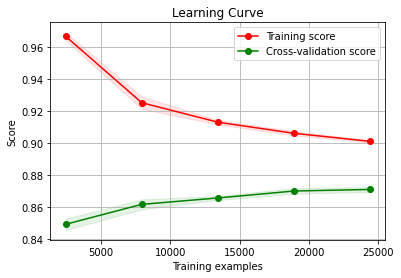

In [46]:
model = xgb.XGBClassifier(**xgb_params)
plot_learning_curve(model, X, y, cv=4, random_state=0, shuffle=True)